## Dataset information as per Kaggle (https://www.kaggle.com/competitions/icr-identify-age-related-conditions/data)

1. **train.csv** - The training set.
   * `Id` Unique identifier for each observation.
   * `AB-GL` Fifty-six anonymized health characteristics. All are numeric except for EJ, which is categorical.
   * `Class` A binary target: 1 indicates the subject has been diagnosed with one of the three conditions, 0 indicates they have not.
2. **test.csv** - The test set. Your goal is to predict the probability that a subject in this set belongs to each of the two classes.
3. **greeks.csv** - Supplemental metadata, only available for the training set.
   * `Alpha` Identifies the type of age-related condition, if present.
     * `A` No age-related condition. Corresponds to class 0.
     * `B`, `D`, `G` The three age-related conditions. Correspond to class 1.
   * `Beta`, `Gamma`, `Delta` Three experimental characteristics.
   * `Epsilon` The date the data for this subject was collected. Note that all of the data in the test set was collected after the training set was collected.

In [3]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf, keras, and sklearn
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

from mlxtend.plotting import heatmap

# Stats library
import statsmodels.api as sm

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

In [4]:
greeks = pd.read_csv('../data/greeks.csv')
test = pd.read_csv('../data/test.csv')
train = pd.read_csv('../data/train.csv')

greeks.columns = map(str.lower, greeks.columns)
test.columns = map(str.lower, test.columns)
train.columns = map(str.lower, train.columns)

print('Shape of greeks df:', greeks.shape)
print('Shape of test df:', test.shape)
print('Shape of train df:', train.shape)

# Merge train and greeks to get all columns in the same DataFrame
df = pd.merge(train, greeks, on='id')

Shape of greeks df: (617, 6)
Shape of test df: (5, 57)
Shape of train df: (617, 58)


In [5]:
# One-hot encode EJ so it could be used in tSNE or PCA
train = train.join(pd.get_dummies(train['ej'], dtype=int))
train.drop(['ej'], axis=1, inplace=True)

# Binary target variable
target_variable = train['class']
features_variable = train.drop(['class', 'id'], axis=1)

# Fill in NaN values via KNNImputer
imputer = KNNImputer(n_neighbors=2)
features_variable = pd.DataFrame(imputer.fit_transform(features_variable))

features_variable.columns = train.drop(['class', 'id'], axis=1).columns

In [6]:
def feature_reduction(method = 'pca', num_features = 24, data_split = 0.2, kernel = 'rbf'):
    """Reduces features depending on inputs
    
    params:
    -------
    method: str, method selection for reduction. Options are pca, kpca, or tsne
    num_features: int, number of features to retain after reduction
    data_split: float, percentage split for train and test
    kernel: str, kernel selection for use with kPCA
    
    return:
    -------
    X_train:            X train data
    X_test:             X test data
    Y_train:            Y train data
    Y_test:             Y test data
    EJ_A_X_Test:        X test data for EJ column with A as value
    EJ_B_X_Test:        X test data for EJ column with B as value
    EJ_A_Y_Test:        Y test data for EJ column with A as value
    EJ_B_Y_Test:        Y test data for EJ column with B as value
    X_train_std:        X train std for use with ablation table for decision tree/random forest
    X_test_std:         X test std for use with ablation table for decision tree/random forest
    EJ_A_X_Test_std:    EJ A X Test std without PCA
    EJ_B_X_Test_std:    EJ B X Test std without PCA
    variance_ratio: Variance ratio/relavent statistic for feature reduction
    
    """
    if method == 'pca' or method == 'kpca':
        # Split into Train and Test
        X_train, X_test, Y_train, Y_test = train_test_split(features_variable, target_variable, test_size = data_split,
                                                            stratify=target_variable, random_state=0)
        
        EJ_A_X_Test = X_test[X_test['A'] == 1]
        EJ_A_Y_Test = Y_test[X_test['A'] == 1]

        EJ_B_X_Test = X_test[X_test['B'] == 1]
        EJ_B_Y_Test = Y_test[X_test['B'] == 1]
        
        # Standardize values via StandardScaler
        sc = StandardScaler().fit(X_train)

        X_train_std = sc.transform(X_train)
        X_test_std = sc.transform(X_test)

        EJ_A_X_Test_std = sc.transform(EJ_A_X_Test)
        EJ_B_X_Test_std = sc.transform(EJ_B_X_Test)

        # PCA/kPCA
        if method == 'pca':
            pca = PCA(n_components = num_features)
            pca.fit(X_train_std)
            variance_ratio = np.cumsum(pca.explained_variance_ratio_) * 100

        elif method == 'kpca':
            pca = KernelPCA(n_components = num_features, kernel = kernel)
            pca.fit(X_train_std)

            # kPCA does not have a feature for explained_variance_ratio_
            # because of the kernel transformation. The once the transformation
            # occurs, the data lives in a different feature space.
            # https://stackoverflow.com/a/40687862

            variance_ratio = None

        X_train_pca = pd.DataFrame(pca.transform(X_train_std))
        X_test_pca = pd.DataFrame(pca.transform(X_test_std))

        EJ_A_X_Test_pca = pd.DataFrame(pca.transform(EJ_A_X_Test_std))
        EJ_B_X_Test_pca = pd.DataFrame(pca.transform(EJ_B_X_Test_std))

        return X_train_pca, X_test_pca, Y_train, Y_test, EJ_A_X_Test_pca, EJ_B_X_Test_pca, EJ_A_Y_Test, EJ_B_Y_Test, X_train_std, X_test_std, EJ_A_X_Test_std, EJ_B_X_Test_std, variance_ratio

    elif method == 'tsne':
        # Standardize values via StandardScaler
        sc = StandardScaler().fit(features_variable)
        features_variable_std = sc.transform(features_variable)

        tsne = TSNE(n_components=num_features, random_state=0, perplexity=50, n_iter=5000, method = 'exact')

        # Calculate the 12 features via tSNE model
        features_variable_tsne = pd.DataFrame(tsne.fit_transform(features_variable_std))

        # kl_divergence (lower is better)
        divergence = tsne.kl_divergence_

        #Split into Train and Test
        X_train, X_test, y_train, y_test = train_test_split(features_variable_tsne, target_variable, test_size = data_split,
                                                            stratify=target_variable, random_state=0)
        return X_train, X_test, y_train, y_test, None, None, None, None, None, None, divergence

In [7]:
X_train, X_test, Y_train, Y_test, EJ_A_X_Test, EJ_B_X_Test, EJ_A_Y_Test, EJ_B_Y_Test, X_train_std, X_test_std, EJ_A_X_Test_std, EJ_B_X_Test_std, statistic = feature_reduction(method='pca', num_features=24, data_split=0.2)

In [8]:
display(X_train.head())

# Display old features shape
display(features_variable.shape)

# Display new tSNE features shape
display(X_train.shape)

0         1         2         3         4         5         6    
0 -0.690887  0.685788  1.006226 -1.171854  0.136816  0.093421 -0.481733  \
1 -0.441772  0.454223  1.462607 -0.617965 -0.293618  0.023432  0.153689   
2  0.671402 -1.941961 -1.723888  0.351624  0.629489  1.202796  1.880502   
3 -1.129595 -1.193760  1.500116 -0.829614  0.123395  0.421081  1.446770   
4 -0.449661  0.533336 -2.227092  1.630291 -0.744035 -0.592698  0.645509   

         7         8         9   ...        14        15        16        17   
0  0.392191 -0.176123 -0.091700  ...  0.838373 -1.056261  0.535441  1.200978  \
1 -1.660740 -0.165092  0.878005  ...  0.786217 -1.216243  0.658438  0.838084   
2  1.530765 -0.002930  0.937556  ...  1.091466  0.823074 -0.526456 -0.124357   
3 -1.168590  0.334539  0.943517  ...  1.113140 -0.061908 -0.002122 -0.511413   
4 -0.155894 -1.008784  0.356228  ... -0.789424  0.171670  0.285349  0.590511   

         18        19        20        21        22        23  
0 -0.158611 -0.077590 -0.139836 -0.224102 -0.726805 -0.018811  
1  0.360564 -0.085385 -0.239045 -0.435239 -0.537305 -0.387489  
2 -0.583080 -0.040892  0.021261  1.472451 -0.945578  0.924031  
3  0.160301  0.051340 -1.812252  0.043625  0.140780 -0.521942  
4 -0.380552 -0.343775 -0.816738 -0.552360 -0.553257 -0.493903  

[5 rows x 24 columns]

(617, 57)

(493, 24)

# EDA Visualizations

Below are visualizations of the following:

1. Heatmap before feature reduction
2. Distribution of features before reduction
3. Distribution of features after reduction
4. tSNE cluster visualizations
5. PCA variance graph

### Correlation Heatmap before feature reduction

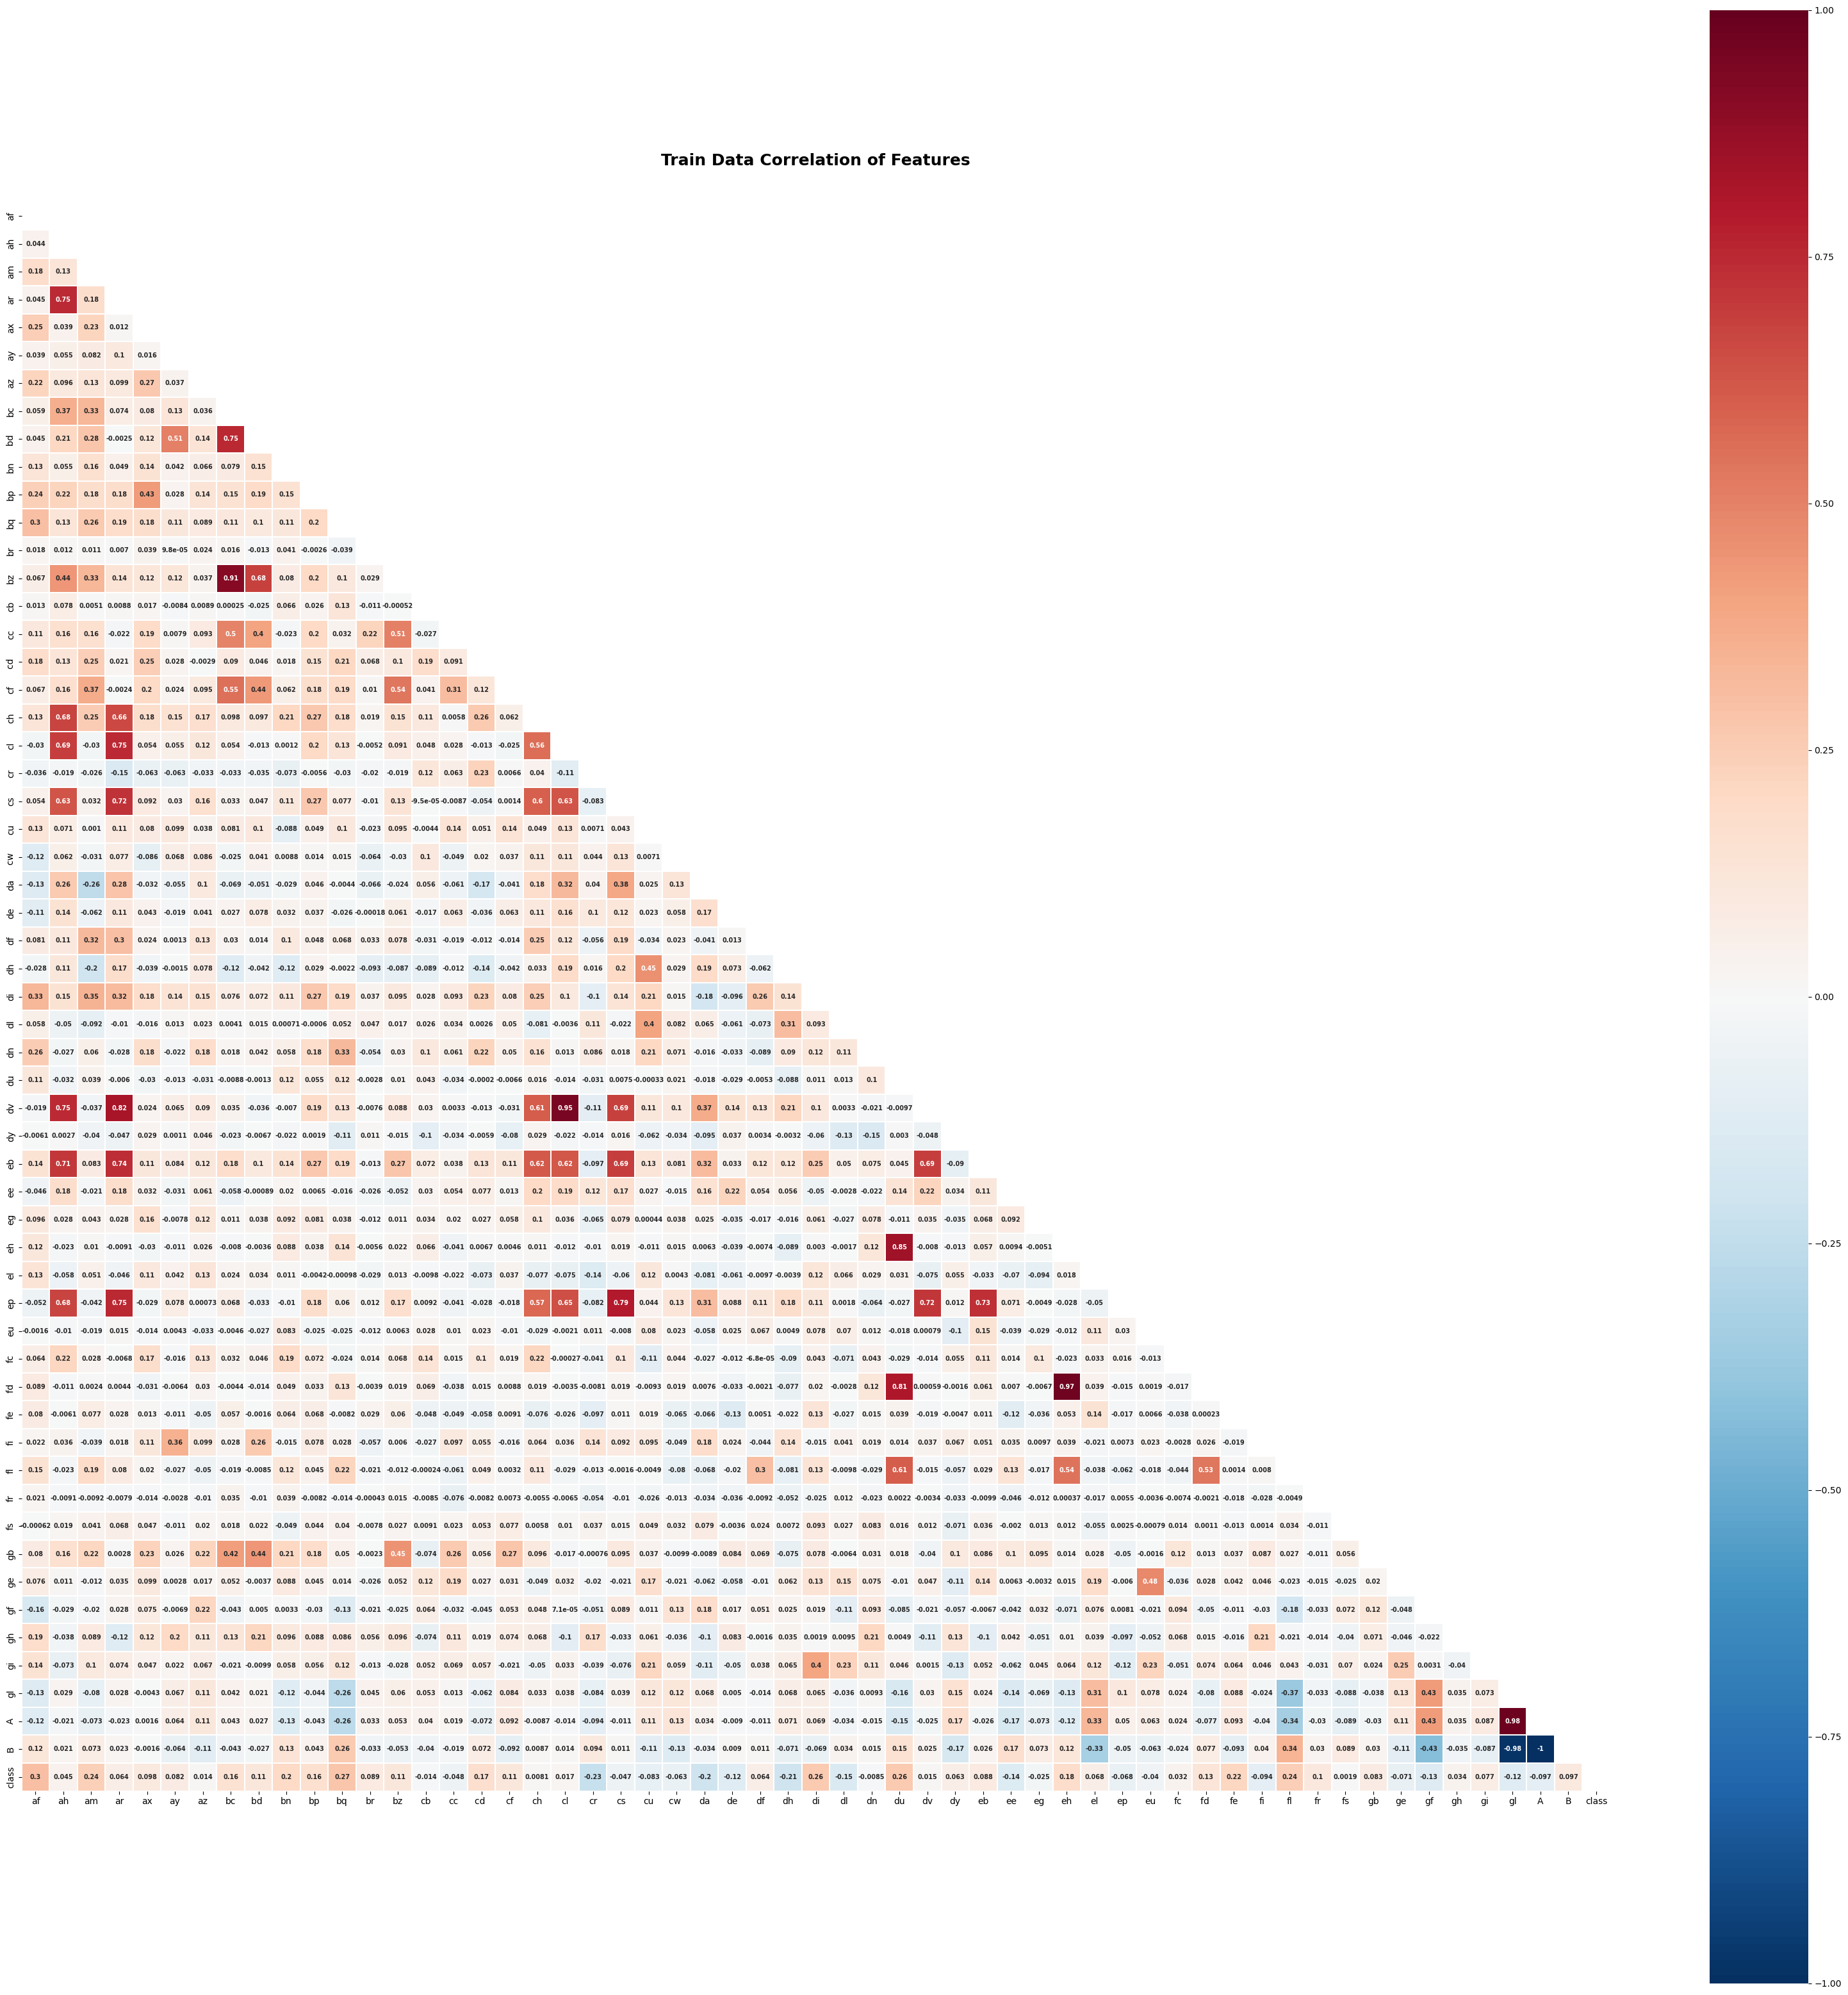

In [9]:
cm_df = features_variable.join(target_variable)

def plot_heatmap(df, title):
    # Create a mask for the diagonal elements
    mask = np.zeros_like(df.astype(float).corr())  
    mask[np.triu_indices_from(mask)] = True

    # Set the colormap and figure size
    colormap = plt.cm.RdBu_r
    plt.figure(figsize=(40, 40))

    # Set the title and font properties
    plt.title(f'{title} Correlation of Features', fontweight='bold', y=1.02, size=18)

    # Plot the heatmap with the masked diagonal elements
    sns.heatmap(df.astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 7, "weight": "bold"},
                mask=mask)

plot_heatmap(cm_df.iloc[:, 1:], title='Train Data')

plt.savefig('./images/heatmap.png', dpi=300)

### Distribution of features before reduction

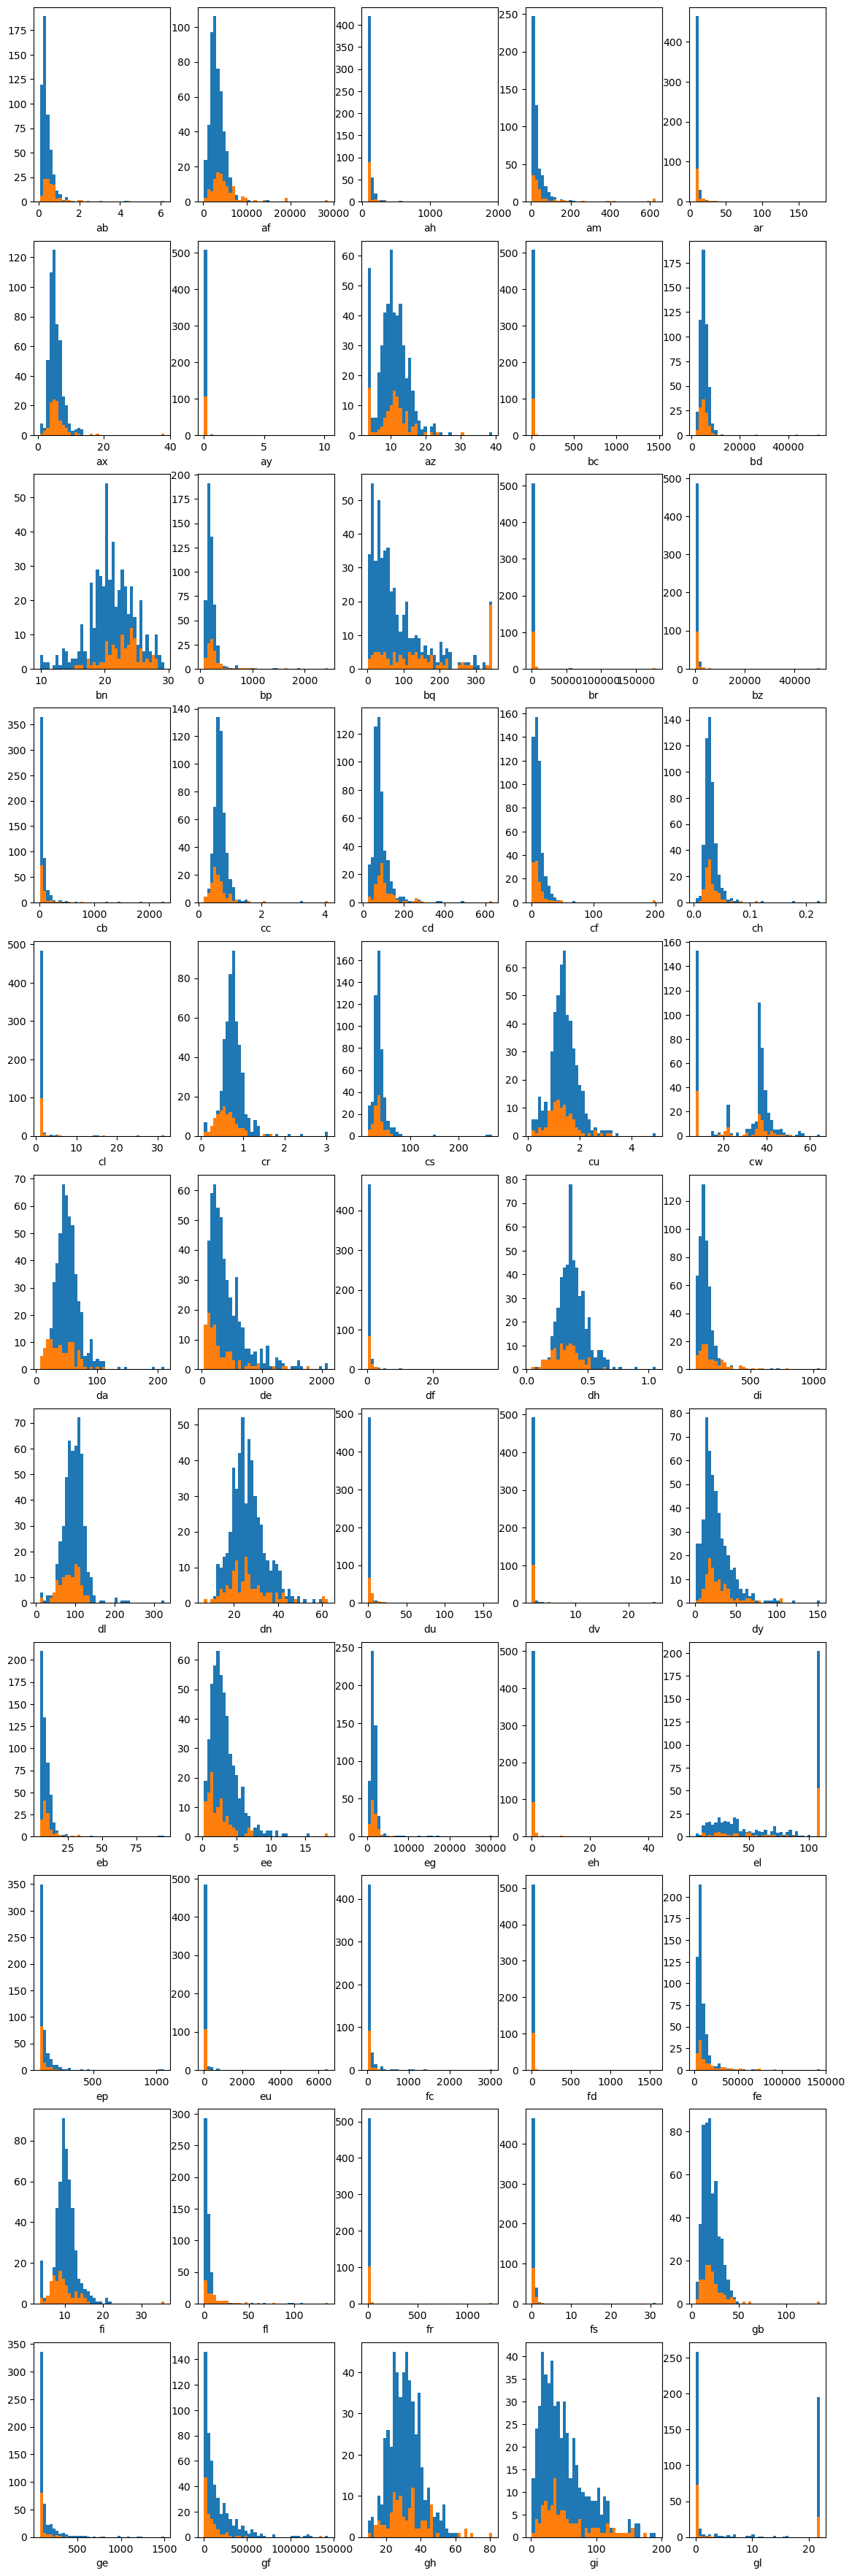

In [10]:
df_train = pd.DataFrame(features_variable).join(target_variable)
columns = list(df_train.columns)
fig, axes = plt.subplots(nrows=11, ncols=5, figsize=(14,45))
for idx, ax in enumerate(axes.flatten()):
    no_disease = df_train[df_train['class']==0][columns[idx]]
    disease = df_train[df_train['class']!=0][columns[idx]]
    bins=np.histogram(np.hstack((no_disease,disease)), bins=40)[1]
    ax.hist(no_disease, bins)
    ax.hist(disease, bins)
    ax.set_xlabel(columns[idx])
plt.savefig('./images/distribution_all.png', dpi=300)

### Distributions after feature reduction colored by outcome (Graphs hardcoded for 23 features after PCA)

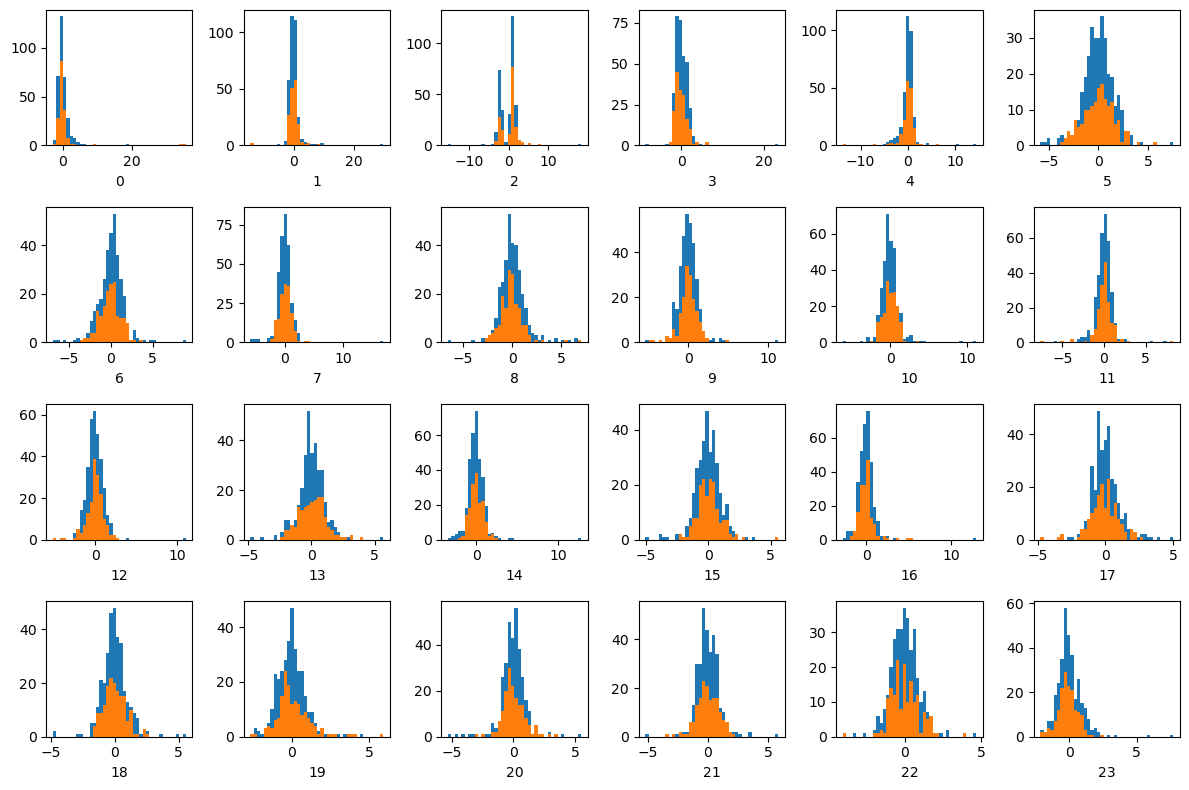

In [11]:
df_train_reduced = pd.DataFrame(X_train).join(Y_train)
columns = list(X_train.columns)
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(12,8))
for idx, ax in enumerate(axes.flatten()):
    no_disease = df_train_reduced[df_train_reduced['class']==0][columns[idx]]
    disease = df_train_reduced[df_train_reduced['class']!=0][columns[idx]]
    bins=np.histogram(np.hstack((no_disease,disease)), bins=40)[1]
    ax.hist(no_disease, bins)
    ax.hist(disease, bins)
    ax.set_xlabel(columns[idx])
plt.tight_layout()
plt.savefig('./images/distribution_reduced.png', dpi=300)

### Visualizing clusting with tSNE feature reduction

First we generate the 55 tSNE feature reductions with perplexities of 5, 10, 15, 20, 25, 30, 35, 40, 45, & 50 with iterations of 250, 500, 750, 1000, and 2000. Then we plot them in a 10x5 grid to visually see if any produce any linearly separable results.

In [12]:
data = []
params = []
for i in (5, 10, 15, 20, 25, 30, 35, 40, 45, 50):
    for j in (250, 500, 750, 1000, 2000):
        n_components = 2
        tsne = TSNE(n_components, perplexity = i, learning_rate = 10, n_iter = j)
        tsne_result = tsne.fit_transform(features_variable)
        tsne_result.shape
        # (1000, 2)
        # Two dimensions for each of our images
        
        # Plot the result of our TSNE with the label color coded
        # A lot of the stuff here is about making the plot look pretty and not TSNE
        tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0],
                                        'tsne_2': tsne_result[:,1],
                                        'label': target_variable})
        data.append(tsne_result_df)
        params.append((i, j))

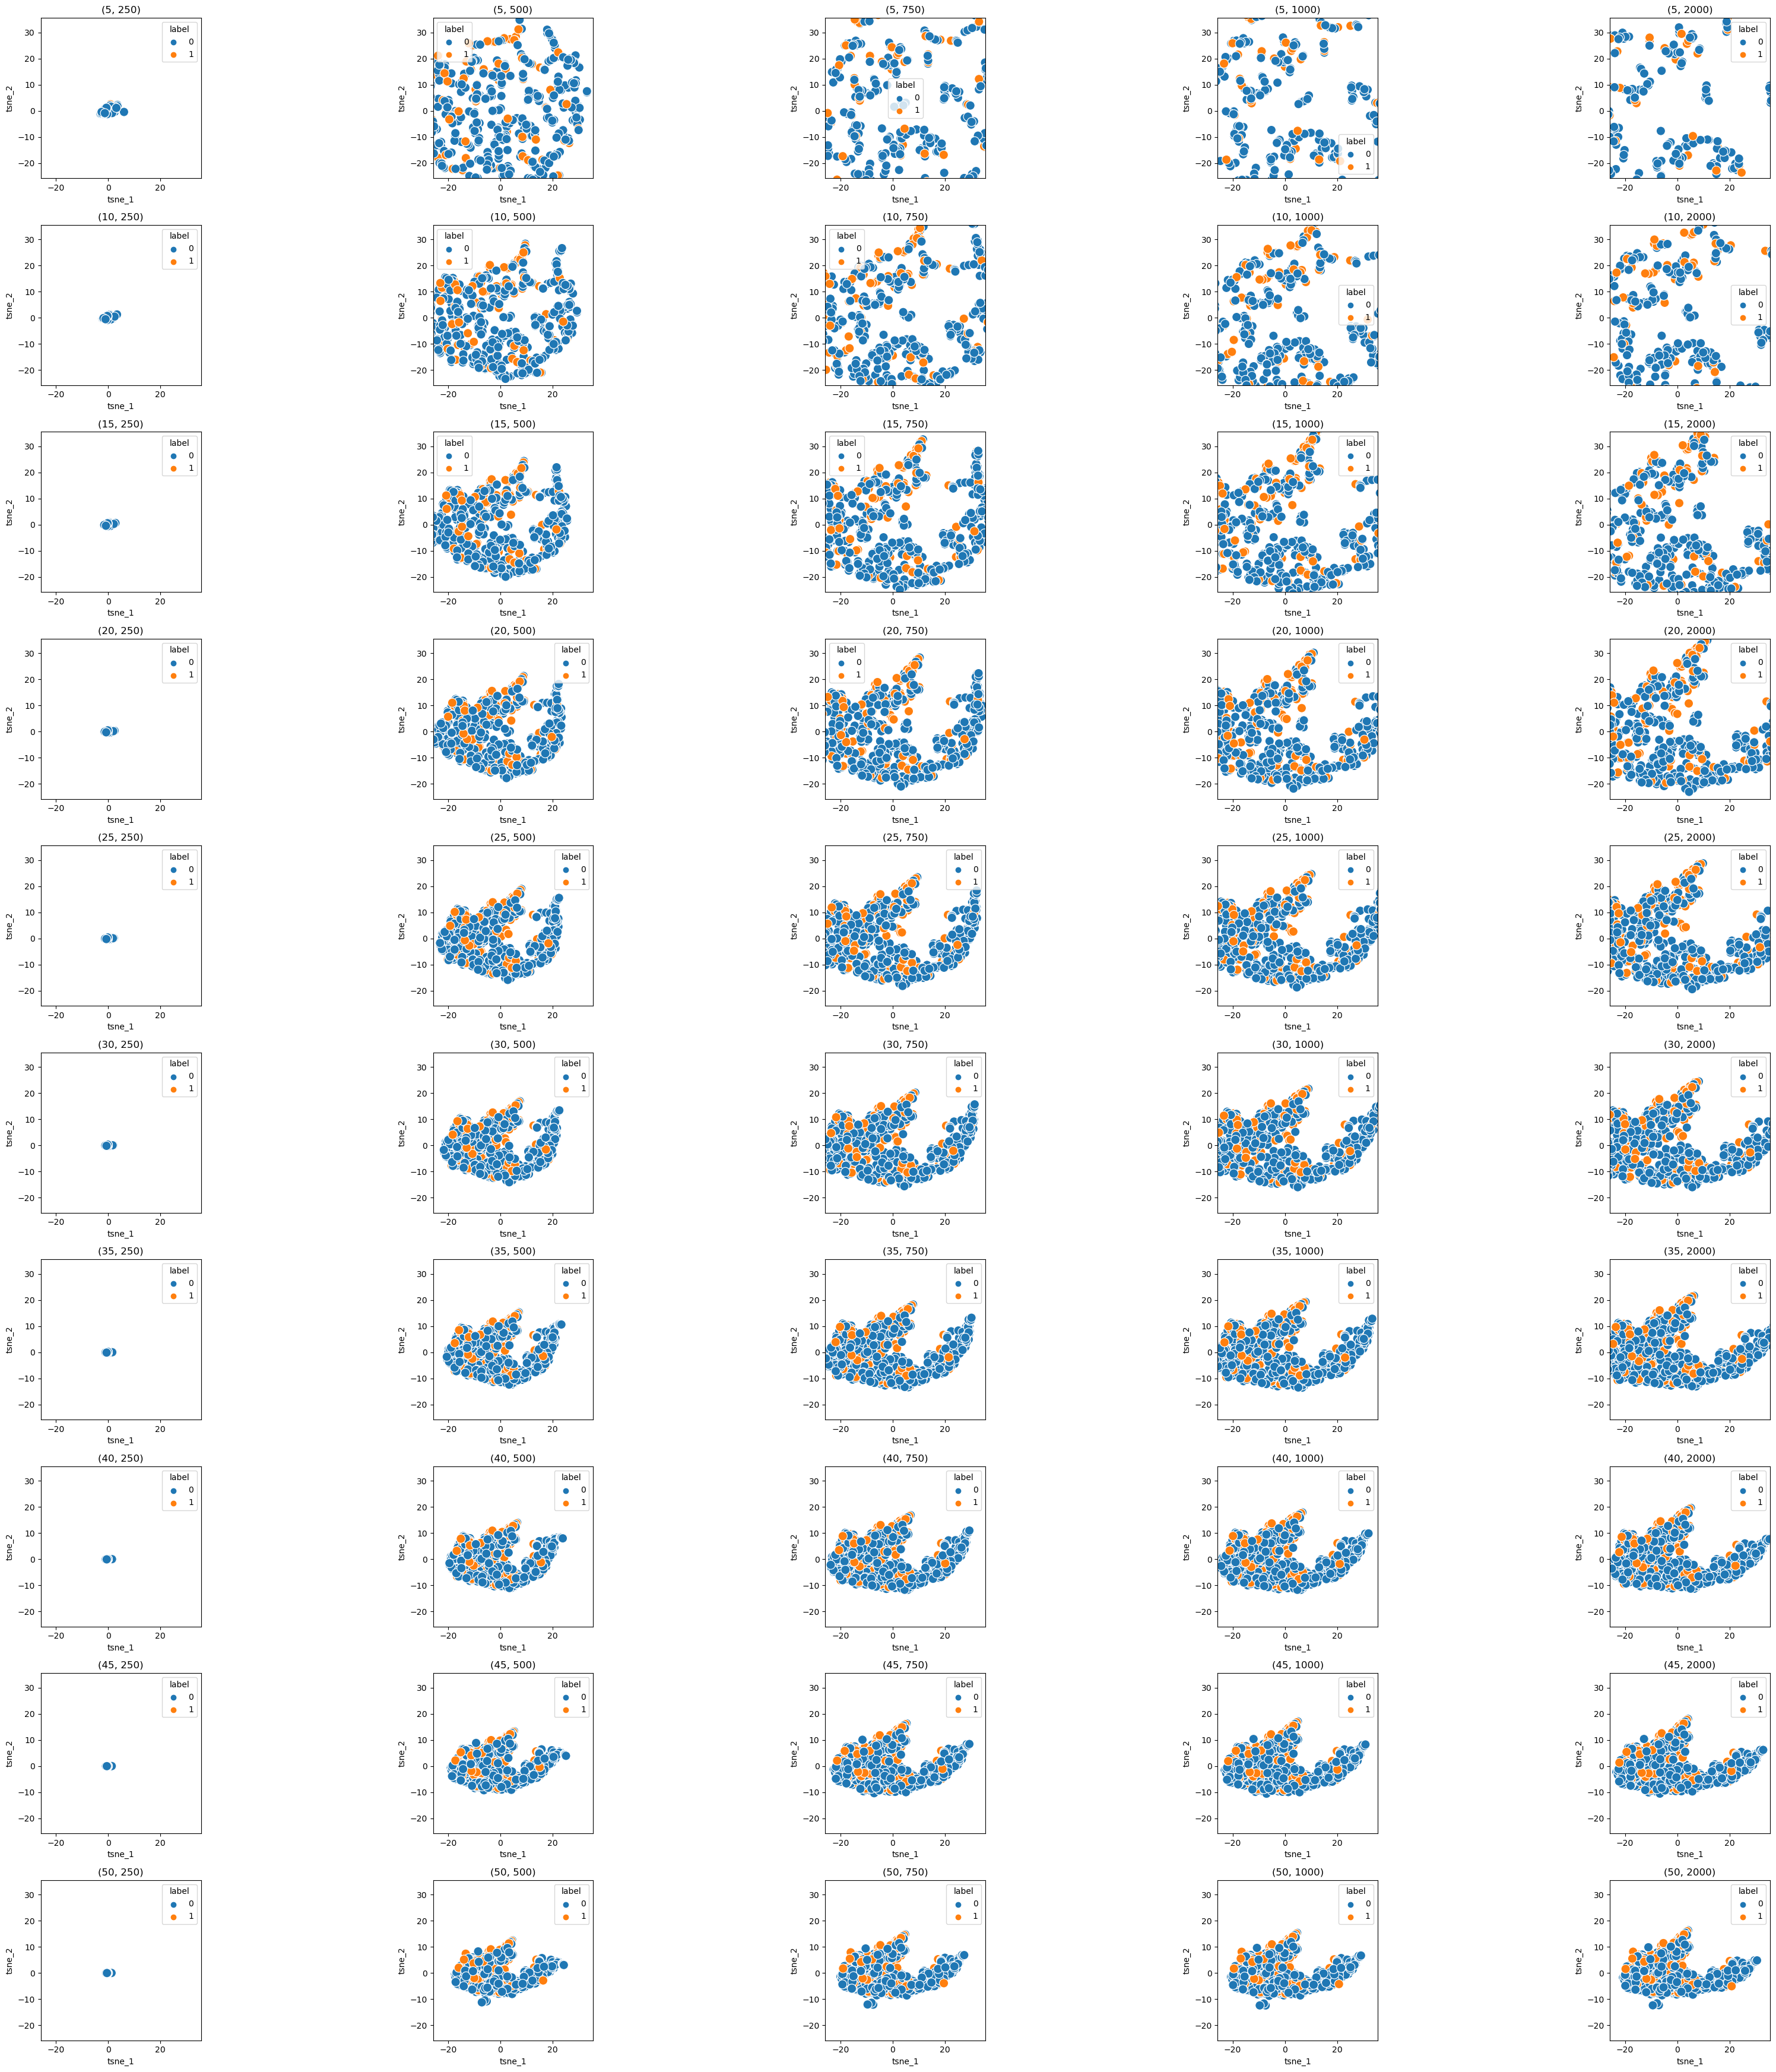

In [13]:
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(35,35))
for idx, ax in enumerate(axes.flatten()):
        sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=data[idx], ax=ax,s=120)
        lim = (tsne_result.min()-5, tsne_result.max()+5)
        ax.set_xlim(lim)
        ax.set_ylim(lim)
        ax.set_aspect('equal')
        ax.set_title(params[idx])
        # ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.tight_layout()
plt.savefig('./images/tsne.png', dpi=300)

### Graph displaying 80%, 90%, and 95% of feature variance is retained via PCA at just 23, 32, and 39 features

Number of principal components explaining 80% of variance: 23
Number of principal components explaining 90% of variance: 32
Number of principal components explaining 95% of variance: 39


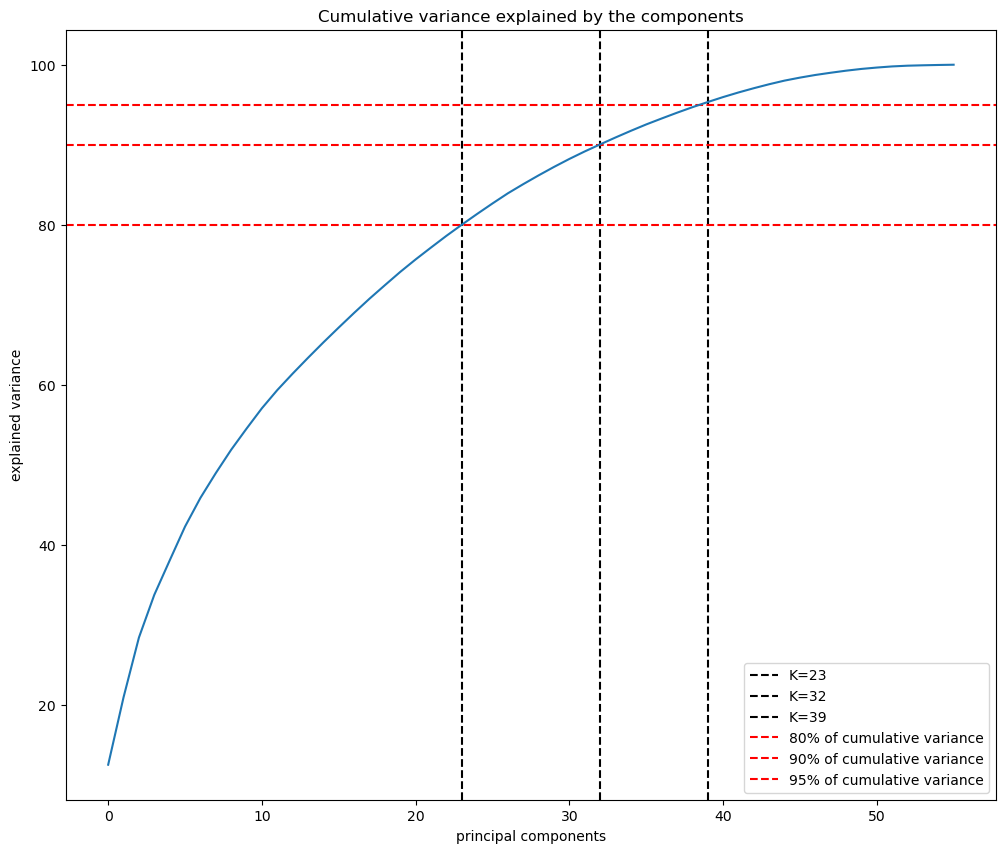

In [14]:
X_train, X_test, y_train, y_test, EJ_A_X_Test, EJ_B_X_Test, EJ_A_Y_Test, EJ_B_Y_Test, X_train_std, X_test_std, EJ_A_X_Test_std, EJ_B_X_Test_std, statistic = feature_reduction(method='pca', num_features=56, data_split=0.2)

# how many principal components explain 95% of the variance?
k80 = np.argmax(statistic > 80)
k90 = np.argmax(statistic > 90)
k95 = np.argmax(statistic > 95)
print("Number of principal components explaining 80% of variance: "+ str(k80))
print("Number of principal components explaining 90% of variance: "+ str(k90))
print("Number of principal components explaining 95% of variance: "+ str(k95))

plt.figure(figsize=[12,10])
plt.title('Cumulative variance explained by the components')
plt.ylabel('explained variance')
plt.xlabel('principal components')
plt.axvline(x=k80, color="k", linestyle="--", label = "K=23")
plt.axvline(x=k90, color="k", linestyle="--", label = "K=32")
plt.axvline(x=k95, color="k", linestyle="--", label = "K=39")
plt.axhline(y=80, color="r", linestyle="--", label="80% of cumulative variance")
plt.axhline(y=90, color="r", linestyle="--", label="90% of cumulative variance")
plt.axhline(y=95, color="r", linestyle="--", label="95% of cumulative variance")
ax = plt.plot(statistic)
              
plt.legend()
plt.savefig('./images/pca_variance.png', dpi=300)

In [15]:
##############################
### Final test and train   ###
### for CSV output for use ###
### in other notebooks     ###
##############################

X_train, X_test, Y_train, Y_test, EJ_A_X_Test, EJ_B_X_Test, EJ_A_Y_Test, EJ_B_Y_Test, X_train_std, X_test_std, EJ_A_X_Test_std, EJ_B_X_Test_std, statistic = feature_reduction(method='pca', num_features=24, data_split=0.2)

# Main outputs
pd.DataFrame(X_train).to_csv('./data/X_train.csv')
pd.DataFrame(X_test).to_csv('./data/X_test.csv')
pd.DataFrame(Y_train).to_csv('./data/Y_train.csv')
pd.DataFrame(Y_test).to_csv('./data/Y_test.csv')

# Outputs for Fairness tests
pd.DataFrame(EJ_A_X_Test).to_csv('./data/EJ_A_X_Test.csv')
pd.DataFrame(EJ_B_X_Test).to_csv('./data/EJ_B_X_Test.csv')
pd.DataFrame(EJ_A_Y_Test).to_csv('./data/EJ_A_Y_Test.csv')
pd.DataFrame(EJ_B_Y_Test).to_csv('./data/EJ_B_Y_Test.csv')

# Outputs for Ablation table
pd.DataFrame(X_train_std).to_csv('./data/X_train_std.csv')
pd.DataFrame(X_test_std).to_csv('./data/X_test_std.csv')
pd.DataFrame(EJ_A_X_Test_std).to_csv('./data/X_train_std.csv')
pd.DataFrame(EJ_B_X_Test_std).to_csv('./data/X_test_std.csv')